# COVID-19 Simulation

COVID-19 is affecting all of us and while most have no accepted we need some kind of social distancing to stop the spread of the virus, one big question remains: how long is this going to take?

The pandemic has sent the world into turmoil and we are moving in to uncharted waters … effectively, we have never experienced a pandemic of this scale AND economic implications … most likely this is also the first time we have captured so much data about a pandemic almost in realtime.

Whenever you need to make predictions about complex situations you have little prior experienced with, models and simuations are a good starting point to explore the situations, test your assumptions, design strategies to deal with the situation and make qualitiative and quantitative predictions about which effect the strategies might have.

This notebook contains such as simulation of the COVID-19 pandemic … though is deliberately kept simple to ensure that users understand the underlying model and assumptions, it already is useful in allowing you to explore the implication of social distancing strategies. We have provided the complete code for the simulation in the form of Jupyter notebooks and Python code on [GitHub](https://github.com/transentis/sim-covid-19), so you can expand on the simulation if you would like to. We have also published an interactive dashboard based on the simulation on [covid-sim.com](https://covid-sim.com), which you can experiment with directly.

The underlying model is an implementation of the [SIR model](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SIR_model), which was developed in 1927 by Kermack and McKendrick to model the spreading of epidemics.

The SIR model is illustrated below using a stock and flow diagram - it is easy to understand, even if you haven't encountered stock and flow diagrams before:

![Image](images/sir_model.png)

The implementation here is roughly calibrated to the situation in Germany (as of 27.3.2020). It illustrates the effects of social distancing in achieving the objective of keeping the strain on the health care system as small as possible.

__Assumptions:__

- Contact Rate: 20 persons. Defines how many people a person encounters per day in average.
- Infectivity: 2%. Defines the probability that a person becomes infected after contact with an infectious person.
- Intensive Care Needed: 0.2%. Measures the number of infected people who need intensive care.
- Intensive Care Available: 30,000 units. The number of intensive care units available.

## System Dynamics Model

The SIR model is implemented in System Dynamics using the [BPTK-Py](http://bptk.transentis-labs.com) framework.

First we need to setup the model class. We let the model run over 1500 days with a time step `dt`of one day.

In [ ]:
from BPTK_Py import Model
from BPTK_Py import sd_functions as sd

model = Model(starttime=1.0,stoptime=1500.0,dt=1.0,name='sir')

### Stocks

Next we set up the stocks. We start with an inital value of 80 Mio. people for the `susceptible`stock (i.e. roughly the German population) and assume we have 120 infected people.

In [2]:
susceptible = model.stock("S")
infectious = model.stock("I")
recovered = model.stock("R")
deaths = model.stock("D")

In [3]:
susceptible.initial_value = 80000000.0
infectious.initial_value = 120.0
recovered.initial_value = 0.0
deaths.initial_value = 0.0

### Flows

In [4]:
infection_rate = model.flow("IR")
recovery_rate = model.flow("RR")
death_rate = model.flow("DR")

### Constants

In [5]:
intensive_rate = model.constant("irate")
infectivity = model.constant("i")
intensive_available = model.constant("available")
lethality = model.constant("L")
average_duration = model.constant("d")
flexible_on=model.constant("flexible_on")
flexible_ref=model.constant("flexible_ref")
normal_contact_rate=model.constant("normal_contact_rate")
distancing_contact_rate=model.constant("distancing_contact_rate")
distancing_begin=model.constant("distancing_begin")
distancing_duration=model.constant("distancing_duration")

### Converters

In [6]:
total_population = model.converter("TP")
net_population = model.converter("N")
intensive_needed = model.converter("needed")

In the basic SIR model the contact rate is simply a constant value, and we assume that the average contact rate is 20 in this notebook.

But we want to experiment with flexible contact rate scenarios, ideally we want to be able to set a different contact rate for each day - but setting a different contact rate for each day is a bit of a hassle in the dashboard, so we will implement two alternatives: 

* a simple one, where you can set the normal contact rate and the social distancing contact rate, the time when you switch from normal to social distancing and how long you keep up the social distancing

* a flexible one, where the contact rate is set for every day.

In [7]:
contact_rate = model.converter("contact_rate")
flexible_contact_rate=model.converter("flexible_contact_rate")
simple_contact_rate=model.converter("simple_contact_rate")

### Equations

The settings for infectivity, lethality and the contact rate are the key settings that determine how quickly the epidemic spreads within the population.

We had to make some educated guesses here, as the true infectivity and lethality are currenty not known.

So we started with the assumtion that each person has 20 contacts per day on average (under normal circumstances, i.e without social distancing) and calibrated the model to the initial development in Germany. This resulted in the assumption of an invectivity of 0.02.

We assume it takes 20 days to recover from the virus and that the lethality is 0.001

In [8]:
susceptible.equation = -infection_rate
infectious.equation = infection_rate - recovery_rate - death_rate
recovered.equation = recovery_rate
deaths.equation = death_rate

In [9]:
infectivity.equation = 0.02
intensive_rate.equation = 0.002
intensive_available.equation = 30000.0
lethality.equation = 0.001
average_duration.equation = 20.0

In [10]:
total_population.equation = susceptible+infectious+recovered
net_population.equation = total_population-deaths
intensive_needed.equation =infectious*intensive_rate

In [24]:
infection_rate.equation = (contact_rate*susceptible*infectivity)*(infectious/total_population)
recovery_rate.equation = sd.min(infectious,infectious/average_duration)
death_rate.equation = sd.min(infectious, infectious*lethality)

Now for the contact rate equations:

In [25]:
contact_rate.equation=flexible_on*flexible_contact_rate+(flexible_ref-flexible_on)*simple_contact_rate
flexible_on.equation=0.0
flexible_ref.equation=1.0
flexible_contact_rate.equation=sd.lookup(sd.time(),"contact_rate")
simple_contact_rate.equation=sd.If(sd.Or(sd.time()<distancing_begin,sd.time()>distancing_begin+distancing_duration),normal_contact_rate,distancing_contact_rate)
normal_contact_rate.equation=20.0
distancing_contact_rate.equation=2.0
distancing_begin.equation=20.0
distancing_duration.equation=200.0

Set the lookup function for the contact rate:

In [13]:
contact_rate_points = []
num_contacts = 20
for t in range(int(model.stoptime)):
    contact_rate_points.append((t,num_contacts))

In [14]:
model.points["contact_rate"]=contact_rate_points

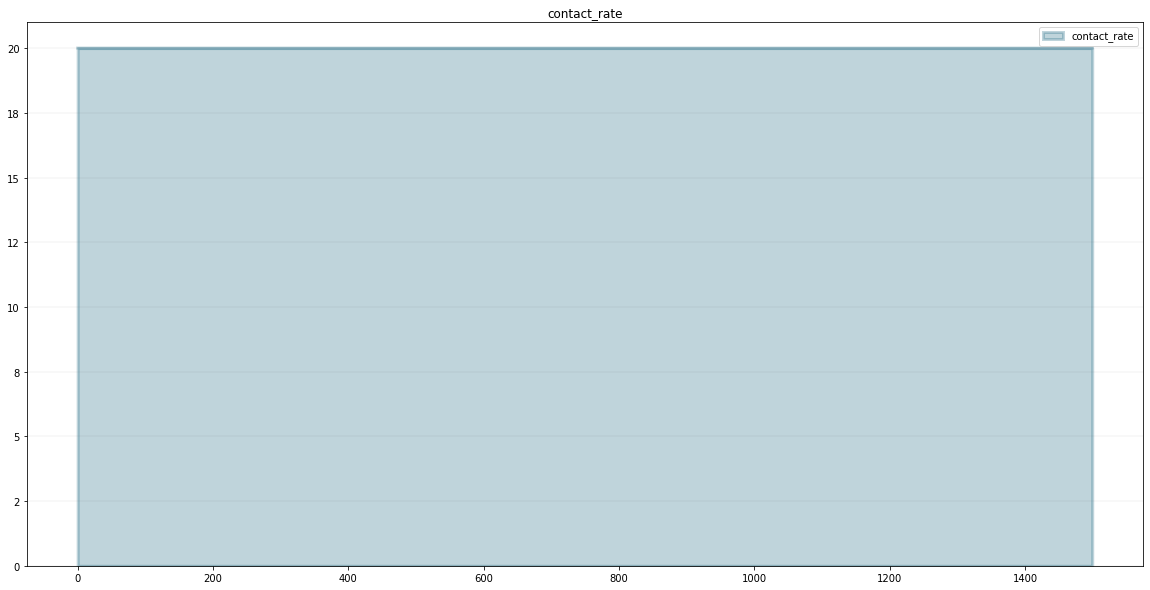

In [15]:
model.plot_lookup("contact_rate")

## Simulation Dashboard

In [16]:
import BPTK_Py
import pandas as pd
bptk = BPTK_Py.bptk()
bptk.register_model(model)

In [17]:
bptk.register_scenarios(
    scenarios ={
        "base": {},
        "contactLargeGroups": {},
        "contactSmallGroups": {},
        "contactTwoPeople": {},
        "interactiveScenario":{}
    },
    scenario_manager="smSir")

In [26]:
%run src/dashboard/sir_dashboard.ipy

GridBox(children=(FloatSlider(value=2.0, continuous_update=False, description='Distancing Contact Rate', layou…

You can also view the dashboard on [covid-sim.com](https://covid-sim.com)

## Scenarios

Now that we have a simulation with the necessary parameters, we can experiment with different scenarios to see what effect social distancing will have and how long it might take before we can get back to a normal situation.

So far we have investigated four scenarios:

* __Base Case.__ In this case we don't change our social behavior and continue as before. The corona virus spreads very quickly, leading to a very high demand on the health care system.
* __Slow social distancing.__ In this case we try to reduce the speed at which the virus spreads, by slowly introducing social distancing. The simulation shows that this hardly has any effect, i.e. the measures taken in Germany to introduce rapid social distancing where right.
* __Rapid social distancing, long-term.__ In this case we introduce rapid social distancing measures and leave them in place for quite some time. The simulation shows that we manage to slow the spread of the virus sufficiently to keep the strain on the health care system low. But unfortunately the measures also take quite some time.
* __Rapid social distancing, short-term.__ In this case we introduce rapid social distancing measures, but ease them very quickly. Unfortunately the simulation shows that this doesn't work - we only manage to move the peak into the future. So unless we manage to come up with other measures such as a vaccine, this strategy will not help.

### Base Case

The base case describes the numbers in Germany and demonstrates what will happen if no measures are taken.

In [19]:
base_scenario= bptk.get_scenario("smSir","base")
base_scenario.constants["flexible_on"]=1.0

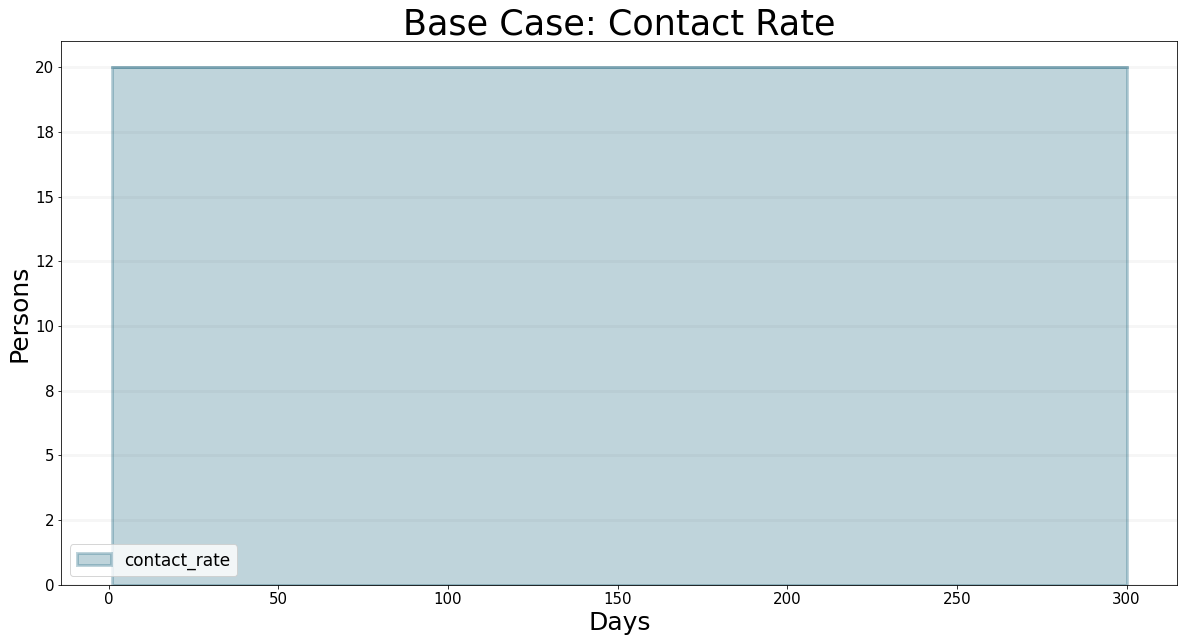

In [20]:
bptk.plot_scenarios(
    scenario_managers=["smSir"],
    scenarios=["base"],
    title="Base Case: Contact Rate",
    x_label="Days",
    y_label="Persons",
    equations=["contact_rate"],
    visualize_to_period=300,
    series_names={
        "smSir_base_c" : "Contact Rate"
    }
)

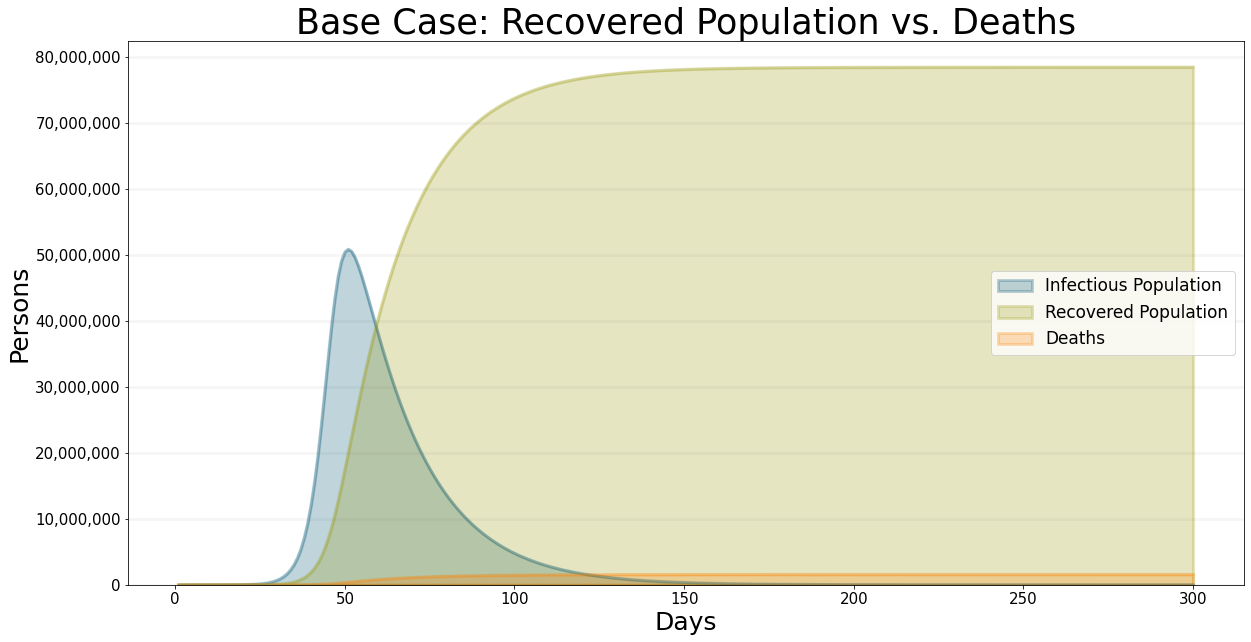

In [21]:
bptk.plot_scenarios(
    scenario_managers=["smSir"],
    scenarios=["base"],
    title="Base Case: Recovered Population vs. Deaths",
    x_label="Days",
    y_label="Persons",
    equations=["I","R","D"],
    visualize_to_period=300,
    series_names={
        "smSir_base_I" : "Infectious Population",
        "smSir_base_R" : "Recovered Population",
        "smSir_base_D": "Deaths"
    }
)

Without any measures the numbers lead to explosive exponential growth as shown in the graph above. The graph below zooms in on the first 25 days - the exponential growth is already visible and the numbers match the situation in Germany well.

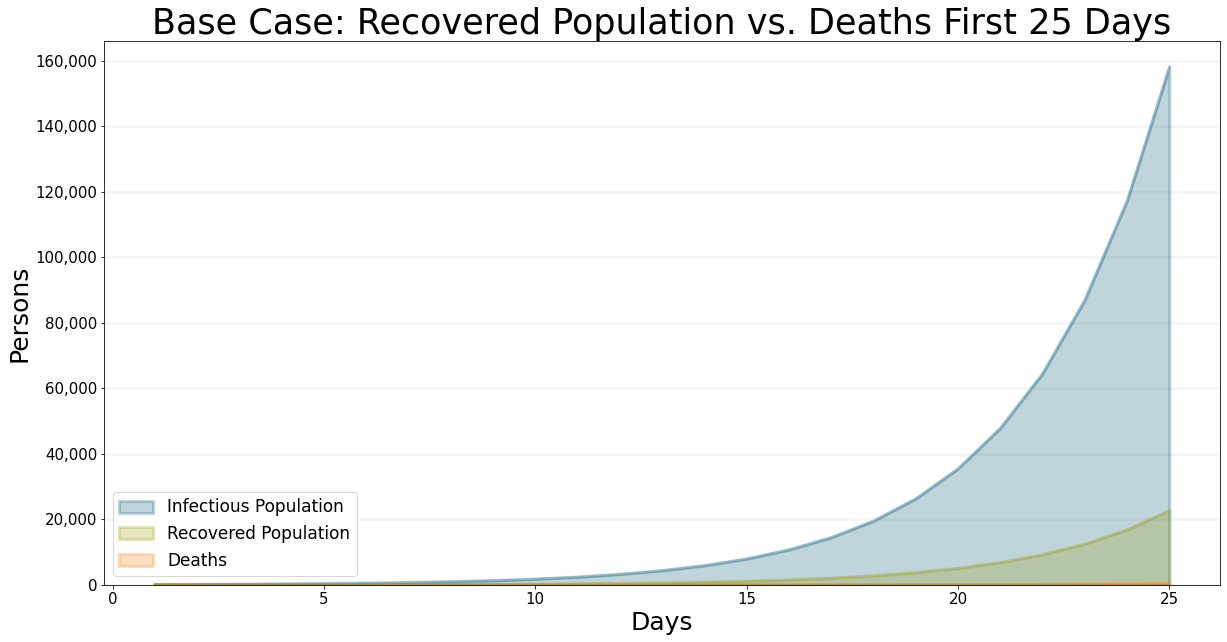

In [22]:
bptk.plot_scenarios(
    scenario_managers=["smSir"],
    scenarios=["base"],
    title="Base Case: Recovered Population vs. Deaths First 25 Days",
    x_label="Days",
    y_label="Persons",
    equations=["I","R","D"],
    series_names={
        "smSir_base_I" : "Infectious Population",
        "smSir_base_R" : "Recovered Population",
        "smSir_base_D": "Deaths"
    },
    visualize_from_period=0,
    visualize_to_period=25
)

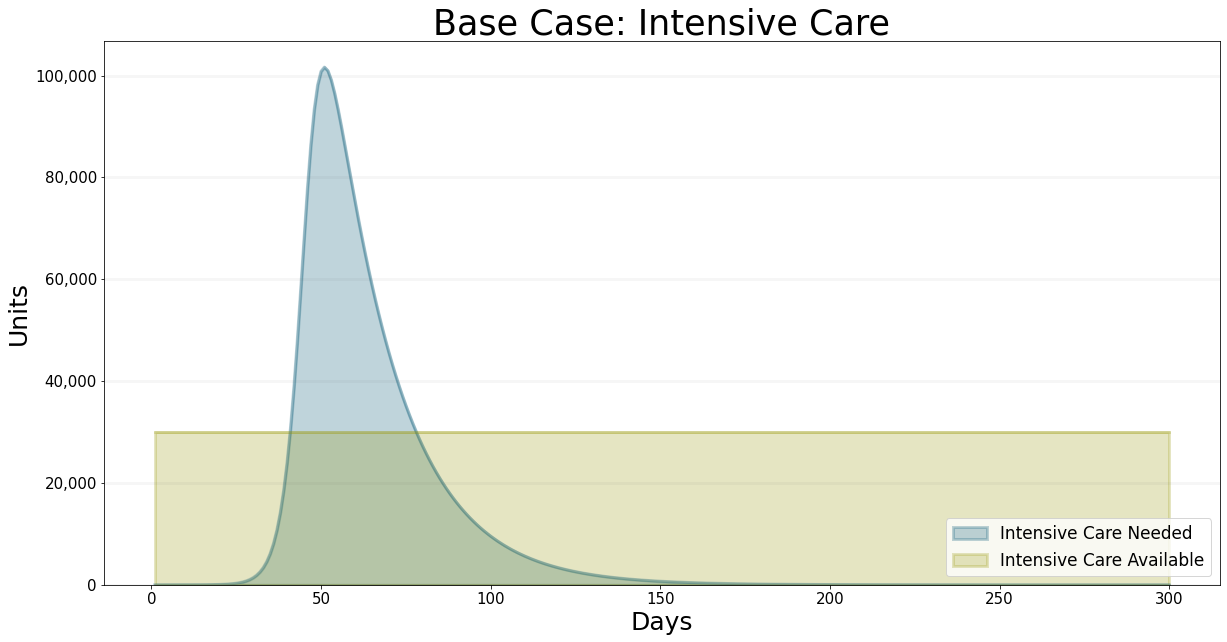

In [23]:
bptk.plot_scenarios(
    scenario_managers=["smSir"],
    scenarios=["base"],
    title="Base Case: Intensive Care",
    x_label="Days",
    y_label="Units",
    equations=["needed","available"],
    series_names={
        "smSir_base_needed" : "Intensive Care Needed",
        "smSir_base_available" : "Intensive Care Available"  
    },
    visualize_to_period=300
)

The simulation also illustrates that there are not enough intensive care units available if the epidemic is left to grow without countermeasures.

### Reducing Spreading of the Virus

The following scenarios show the effect of taking measures. It shows which measures are necessary to avoid the collapse of the health care system.

#### Less contact to other people

We can avoid the spreading of the virus by reducing the contact to other people. In other words, we need to reduce the contact rate. Therefore less people can be infected.

In [18]:
model_small_groups = bptk.scenario_manager_factory.scenario_managers['smSir'].scenarios['contactSmallGroups'].model
stoptime_small_groups = model_small_groups.stoptime

In [19]:
points_list_large = []
contact_large = contact_rate.equation
for t in range(int(model_small_groups.stoptime)):
    if t%40==0 and t!=0 and t < 365:
        contact_large = contact_large - 2
    if t == 600:
        contact_large = 6
    if t == 700:
        contact_large = 10
    if t == 800:
        contact_large = 14
    if t == 900:
        contact_large = 20
    points_list_large.append((t,contact_large))

In [20]:
model_small_groups.points["contactRateLarge"]=points_list_large

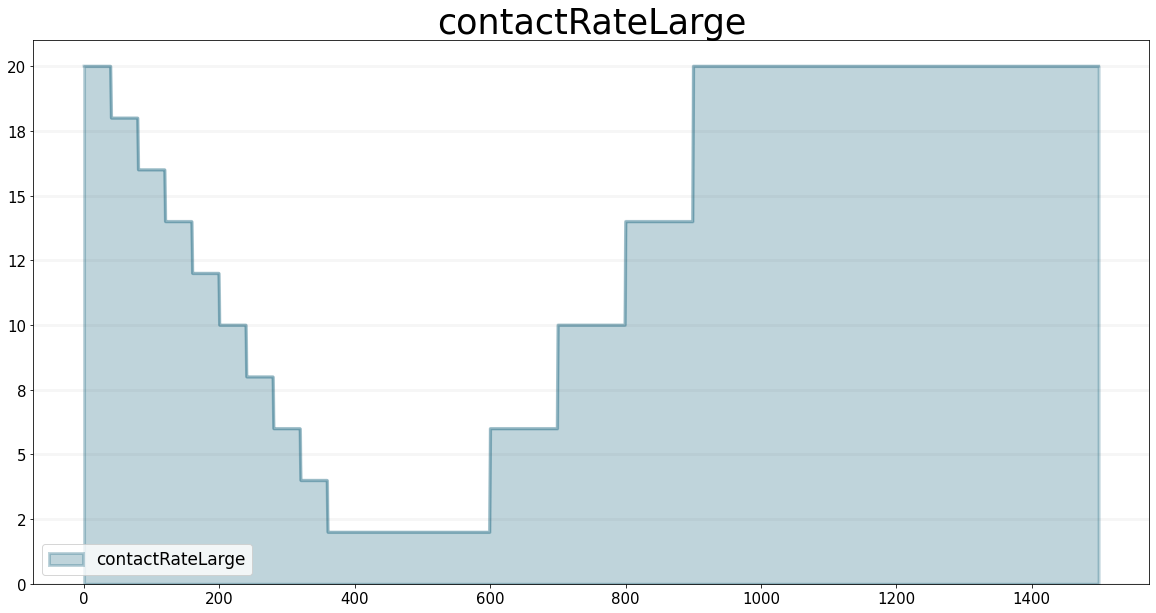

In [21]:
model_small_groups.plot_lookup("contactRateLarge")

In [22]:
model_small_groups.equations["c"].equation=sd.lookup(sd.time(),"contactRateLarge")

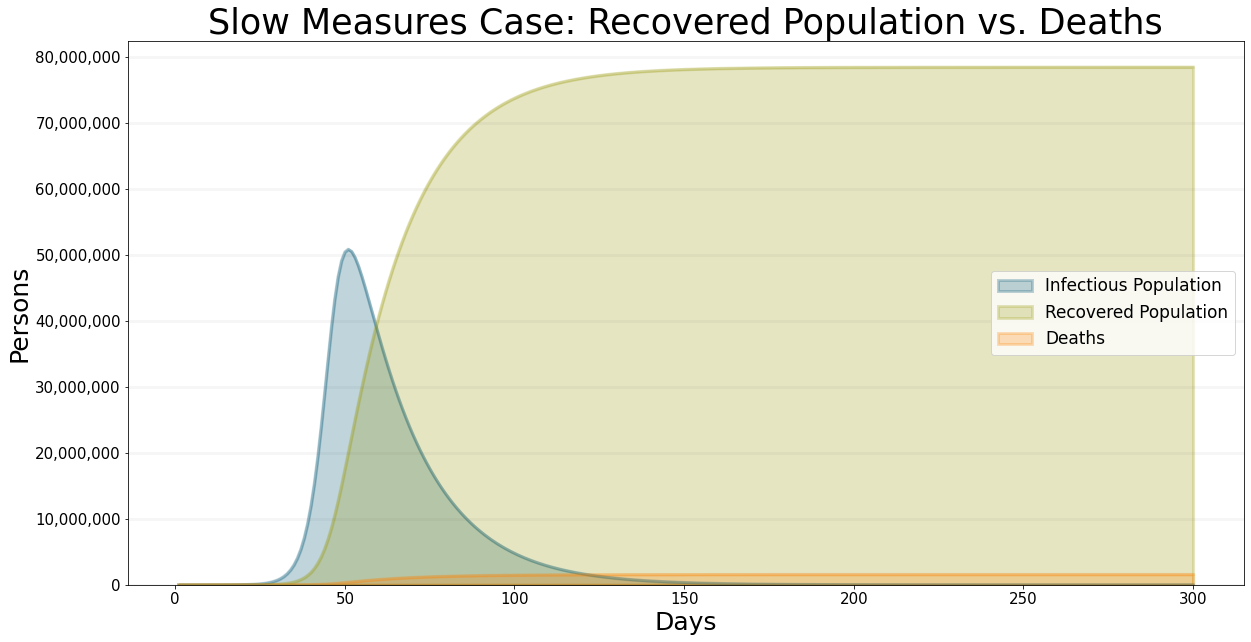

In [23]:
bptk.plot_scenarios(
    scenario_managers=["smSir"],
    scenarios=["contactLargeGroups"],
    title="Slow Measures Case: Recovered Population vs. Deaths",
    x_label="Days",
    y_label="Persons",
    equations=["I","R","D"],
    series_names={
        "smSir_contactLargeGroups_I" : "Infectious Population",
        "smSir_contactLargeGroups_R" : "Recovered Population",
        "smSir_contactLargeGroups_D": "Deaths"
    },
    visualize_to_period=300
)

As you can see from the graph above, the number of the infectious population is still growing exponentially. Comparing the base scenario with this slow measures scenario, we can see that there is no siginificant difference. Taking measures too cautiously doesn't stop the spreading of the virus.

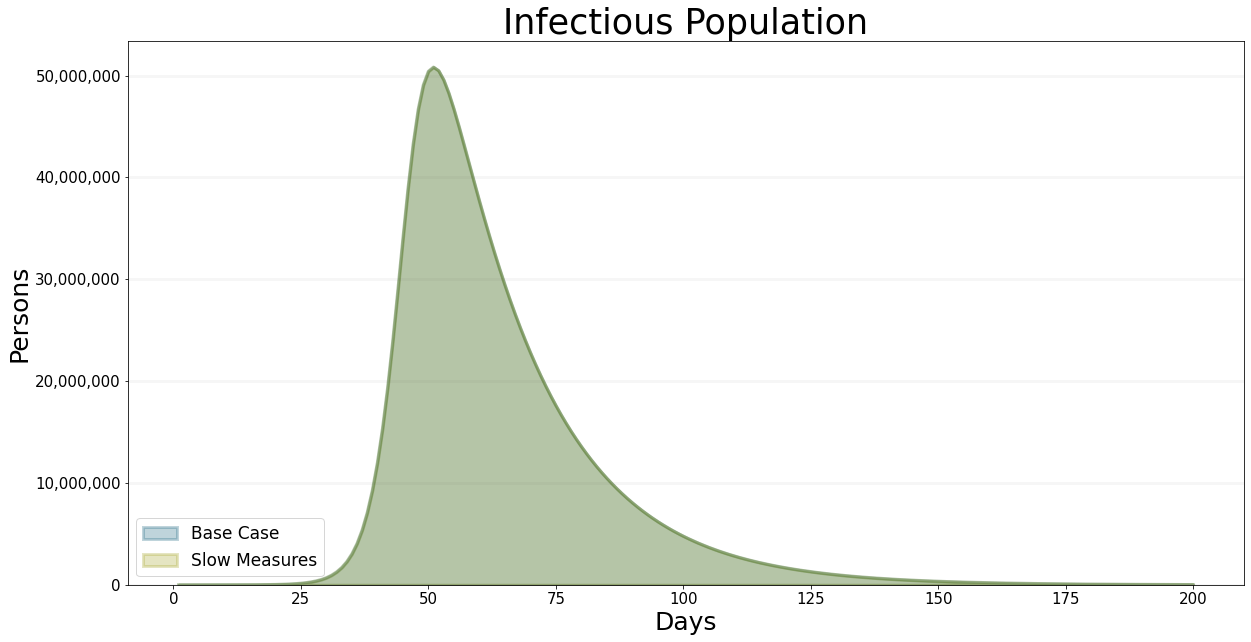

In [24]:
bptk.plot_scenarios(
    scenario_managers=["smSir"],
    scenarios=["contactLargeGroups","base"],
    title="Infectious Population",
    x_label="Days",
    y_label="Persons",
    equations=["I"],
    series_names={
        "smSir_base_I" : "Base Case",
        "smSir_contactLargeGroups_I" : "Slow Measures"
    },
    visualize_to_period=200
    
)

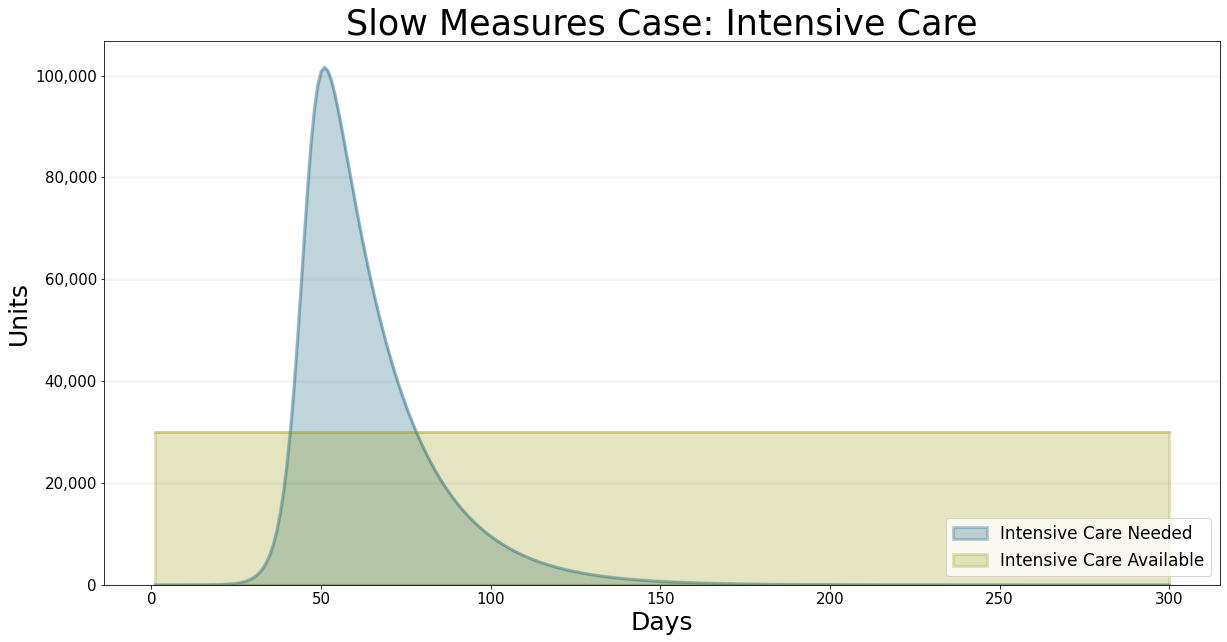

In [31]:
bptk.plot_scenarios(
    scenario_managers=["smSir"],
    scenarios=["contactLargeGroups"],
    title="Slow Measures Case: Intensive Care",
    x_label="Days",
    y_label="Units",
    equations=["needed","available"],
    series_names={
        "smSir_contactLargeGroups_needed" : "Intensive Care Needed",
        "smSir_contactLargeGroups_available" : "Intensive Care Available" 
    },
    visualize_to_period=300
)

#### Strong Social Distancing

In [29]:
model_small_groups = bptk.scenario_manager_factory.scenario_managers['smSir'].scenarios['contactSmallGroups'].model
stoptime_small_groups = model_small_groups.stoptime

points_list_small = []
contact_small = contact_rate.equation
for t in range(int(stoptime_small_groups)):
    if t==25:
        contact_small= 10
    if t==41:
        contact_small = 5
    if t==500:
        contact_small = 10
    if t==1200:
        contact_small = 20
    points_list_small.append((t,contact_small))


model_small_groups.points["contactRateSmall"] = points_list_small
model_small_groups.equations["c"] = sd.lookup(sd.time(),"contacRateSmall")

In [38]:
model.equations["c"]

<function BPTK_Py.systemdynamics.element.Element.generate_function.<locals>.<lambda>(t)>

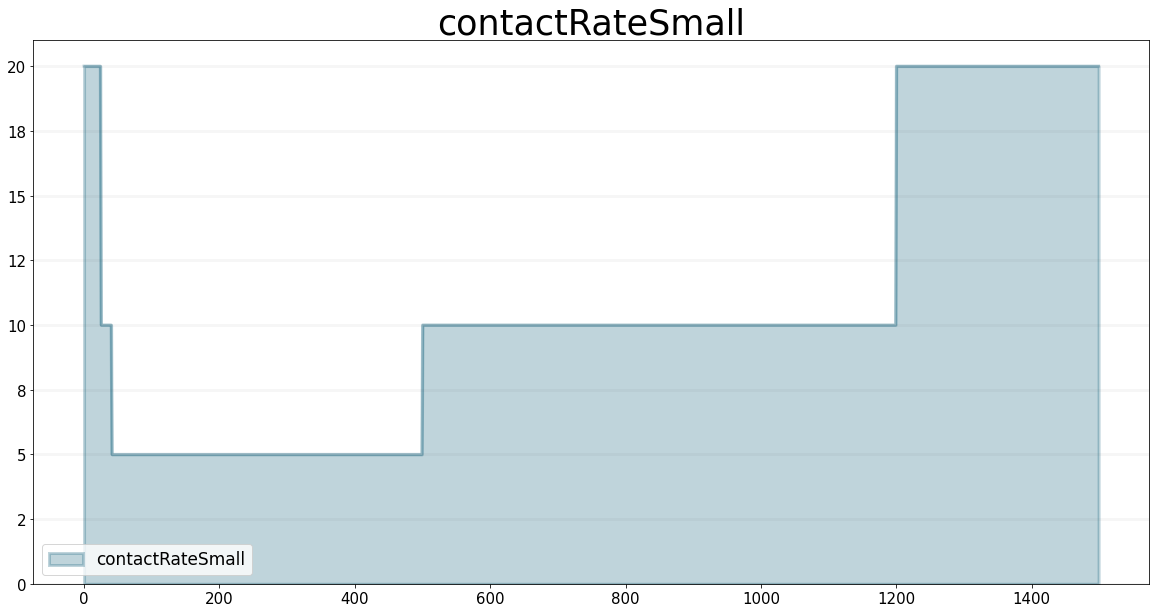

In [30]:
model_small_groups.plot_lookup("contactRateSmall")

Exception in thread Thread-26:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/git/sim-covid-19/venv/lib/python3.6/site-packages/BPTK_Py/sdsimulator/model_simulator.py", line 144, in __simulate
    result = self.mod.equation(equation, i)
  File "/home/ubuntu/git/sim-covid-19/venv/lib/python3.6/site-packages/BPTK_Py/abm/model.py", line 567, in equation
    return self.memoize(equation,arg)
  File "/home/ubuntu/git/sim-covid-19/venv/lib/python3.6/site-packages/BPTK_Py/abm/model.py", line 585, in memoize
    result = self.equations[equation](arg)
  File "/home/ubuntu/git/sim-covid-19/venv/lib/python3.6/site-packages/BPTK_Py/systemdynamics/element.py", line 59, in <lambda>
    self.model.equations[self.name] = lambda t: fn(self.model, t)
  File "<string>", line 1, in <lambda>
  File "/home/ubu

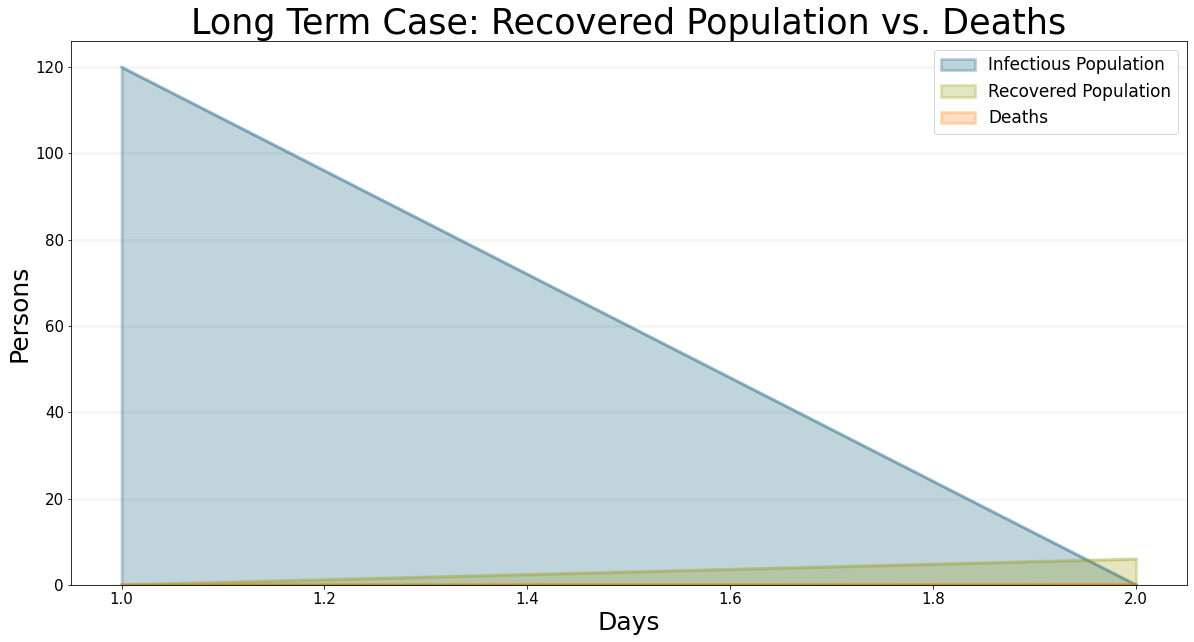

In [31]:
bptk.plot_scenarios(
    scenario_managers=["smSir"],
    scenarios=["contactSmallGroups"],
    title="Long Term Case: Recovered Population vs. Deaths",
    x_label="Days",
    y_label="Persons",
    equations=["I","R","D"],
    series_names={
        "smSir_contactSmallGroups_I" : "Infectious Population",
        "smSir_contactSmallGroups_R" : "Recovered Population",
        "smSir_contactSmallGroups_D": "Deaths"
    },
    visualize_to_period=300
)

The graph shows that the strict measures help to reduce the spreading of the virus. The infectious population does not grow exponentially.

Exception in thread Thread-30:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/git/sim-covid-19/venv/lib/python3.6/site-packages/BPTK_Py/sdsimulator/model_simulator.py", line 144, in __simulate
    result = self.mod.equation(equation, i)
  File "/home/ubuntu/git/sim-covid-19/venv/lib/python3.6/site-packages/BPTK_Py/abm/model.py", line 567, in equation
    return self.memoize(equation,arg)
  File "/home/ubuntu/git/sim-covid-19/venv/lib/python3.6/site-packages/BPTK_Py/abm/model.py", line 585, in memoize
    result = self.equations[equation](arg)
  File "/home/ubuntu/git/sim-covid-19/venv/lib/python3.6/site-packages/BPTK_Py/systemdynamics/element.py", line 59, in <lambda>
    self.model.equations[self.name] = lambda t: fn(self.model, t)
  File "<string>", line 1, in <lambda>
  File "/home/ubu

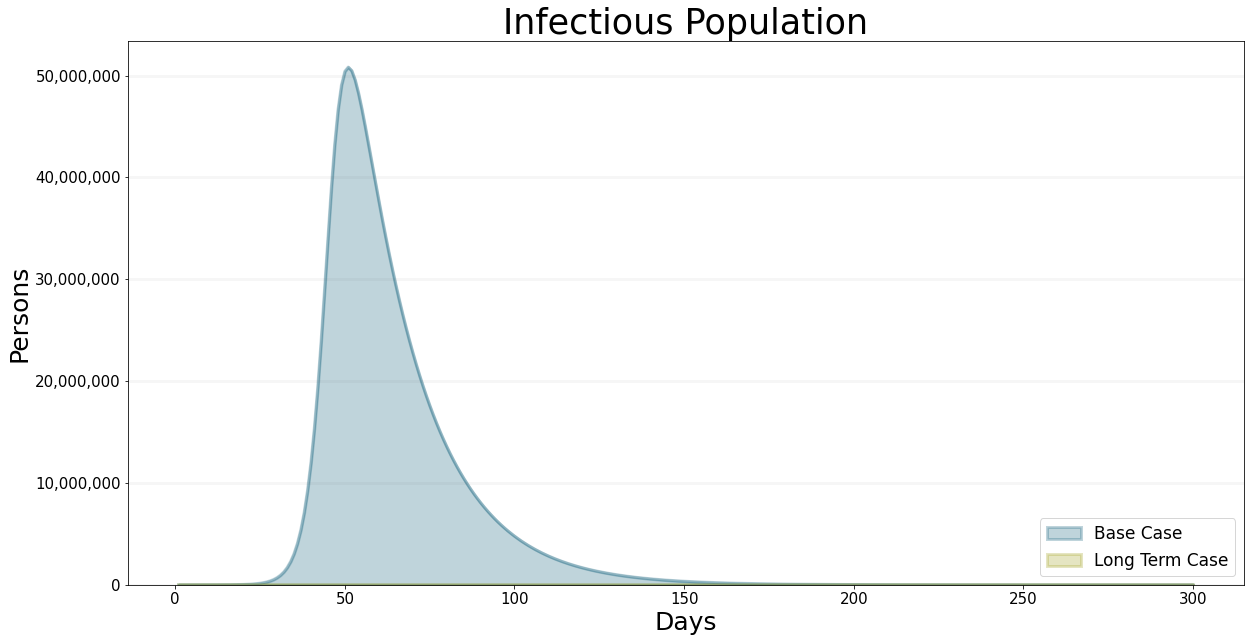

In [33]:
bptk.plot_scenarios(
    scenario_managers=["smSir"],
    scenarios=["contactSmallGroups","base"],
    title="Infectious Population",
    x_label="Days",
    y_label="Persons",
    equations=["I"],
    series_names={
        "smSir_base_I" : "Base Case",
        "smSir_contactSmallGroups_I" : "Long Term Case"
    },
    visualize_to_period=300
    
)

Comparing this scenario with the base scenario we can see how important social distancing is.

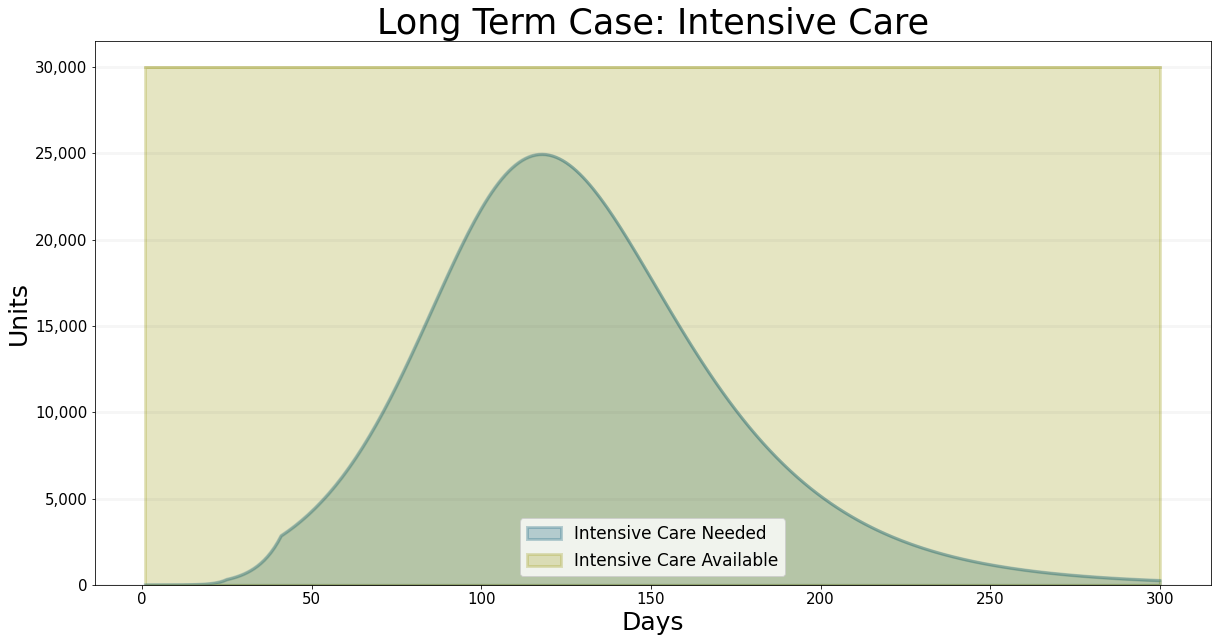

In [27]:
bptk.plot_scenarios(
    scenario_managers=["smSir"],
    scenarios=["contactSmallGroups"],
    title="Long Term Case: Intensive Care",
    x_label="Days",
    y_label="Units",
    equations=["needed","available"],
    series_names={
        "smSir_contactSmallGroups_needed" : "Intensive Care Needed",
        "smSir_contactSmallGroups_available" : "Intensive Care Available" 
    },
    visualize_to_period=300
)

For this scenario there are enough intensive care units available. A collapse of the heath care system won't happen.

#### Reducing contact rate from large groups to two people for only a short period of time

This scenario shows if taking measures radically but loosening them only after a short period of time to avoid the spreading of the virus. We reduce the contact rate to 2 after ten days and increase the contact rate 90 days later to 20.

### Reducing contact rate from large groups to two people for only a short period of time

In [34]:
model_two_people = bptk.scenario_manager_factory.scenario_managers['smSir'].scenarios['contactTwoPeople'].model
stoptime_two_people = model_two_people.stoptime

points_list_two = []
contact_two = 20
for t in range(int(stoptime_two_people)):
    if t==10:
        contact_two = 2
    if t==100:
        contact_two = 20
    points_list_two.append((t,contact_two))


model_two_people.points["contactRateTwo"] = points_list_two
model_two_people.equations["c"] = sd.lookup(sd.time(),"contactRateTwo")

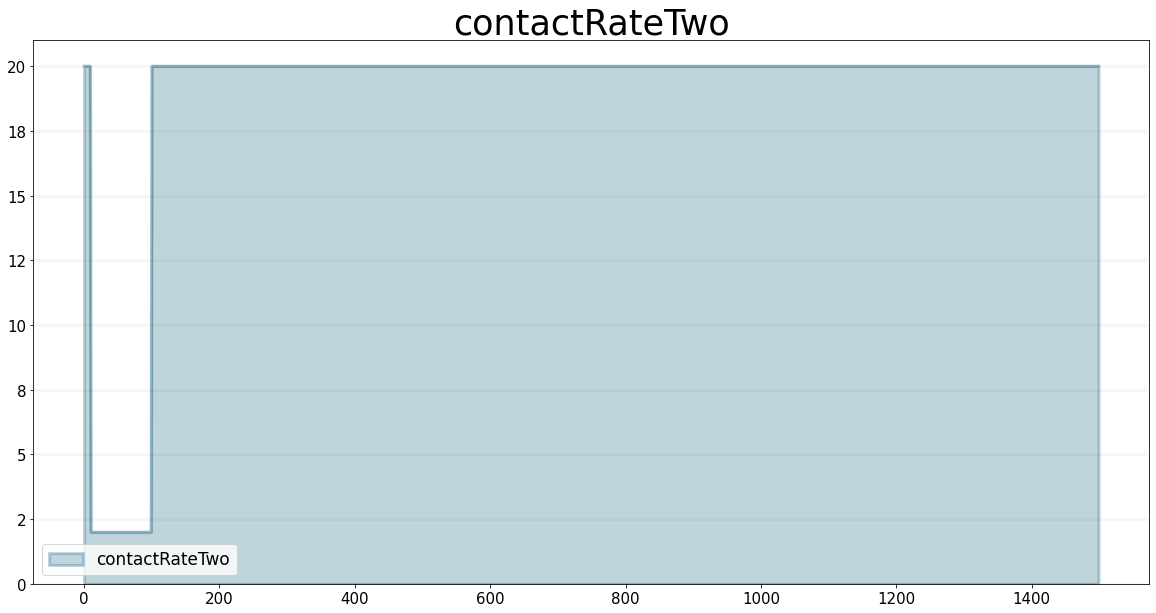

In [35]:
model_two_people.plot_lookup("contactRateTwo")

Exception in thread Thread-32:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/git/sim-covid-19/venv/lib/python3.6/site-packages/BPTK_Py/sdsimulator/model_simulator.py", line 144, in __simulate
    result = self.mod.equation(equation, i)
  File "/home/ubuntu/git/sim-covid-19/venv/lib/python3.6/site-packages/BPTK_Py/abm/model.py", line 567, in equation
    return self.memoize(equation,arg)
  File "/home/ubuntu/git/sim-covid-19/venv/lib/python3.6/site-packages/BPTK_Py/abm/model.py", line 585, in memoize
    result = self.equations[equation](arg)
  File "/home/ubuntu/git/sim-covid-19/venv/lib/python3.6/site-packages/BPTK_Py/systemdynamics/element.py", line 59, in <lambda>
    self.model.equations[self.name] = lambda t: fn(self.model, t)
  File "<string>", line 1, in <lambda>
  File "/home/ubu

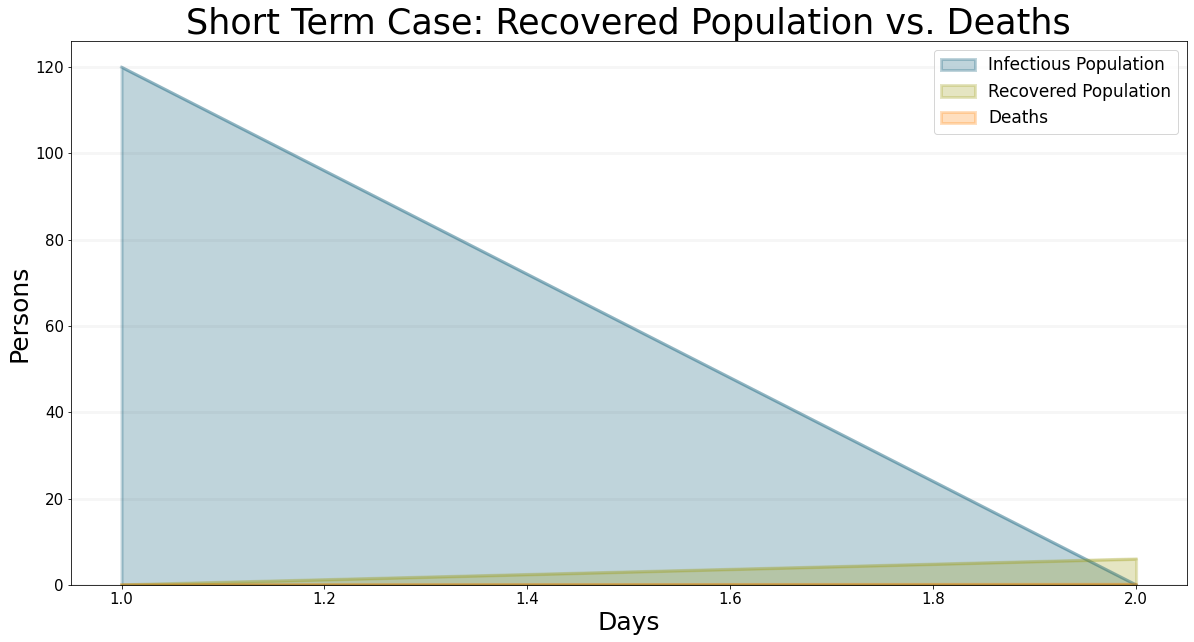

In [36]:
bptk.plot_scenarios(
    scenario_managers=["smSir"],
    scenarios=["contactTwoPeople"],
    title="Short Term Case: Recovered Population vs. Deaths",
    x_label="Days",
    y_label="Persons",
    equations=["I","R","D"],
    series_names={
        "smSir_contactTwoPeople_I" : "Infectious Population",
        "smSir_contactTwoPeople_R" : "Recovered Population",
        "smSir_contactTwoPeople_D": "Deaths"
    },
    visualize_to_period=300
)

Exception in thread Thread-26:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/git/sim-covid-19/venv/lib/python3.6/site-packages/BPTK_Py/sdsimulator/model_simulator.py", line 144, in __simulate
    result = self.mod.equation(equation, i)
  File "/home/ubuntu/git/sim-covid-19/venv/lib/python3.6/site-packages/BPTK_Py/abm/model.py", line 567, in equation
    return self.memoize(equation,arg)
  File "/home/ubuntu/git/sim-covid-19/venv/lib/python3.6/site-packages/BPTK_Py/abm/model.py", line 585, in memoize
    result = self.equations[equation](arg)
  File "/home/ubuntu/git/sim-covid-19/venv/lib/python3.6/site-packages/BPTK_Py/systemdynamics/element.py", line 59, in <lambda>
    self.model.equations[self.name] = lambda t: fn(self.model, t)
  File "<string>", line 1, in <lambda>
  File "/home/ubu

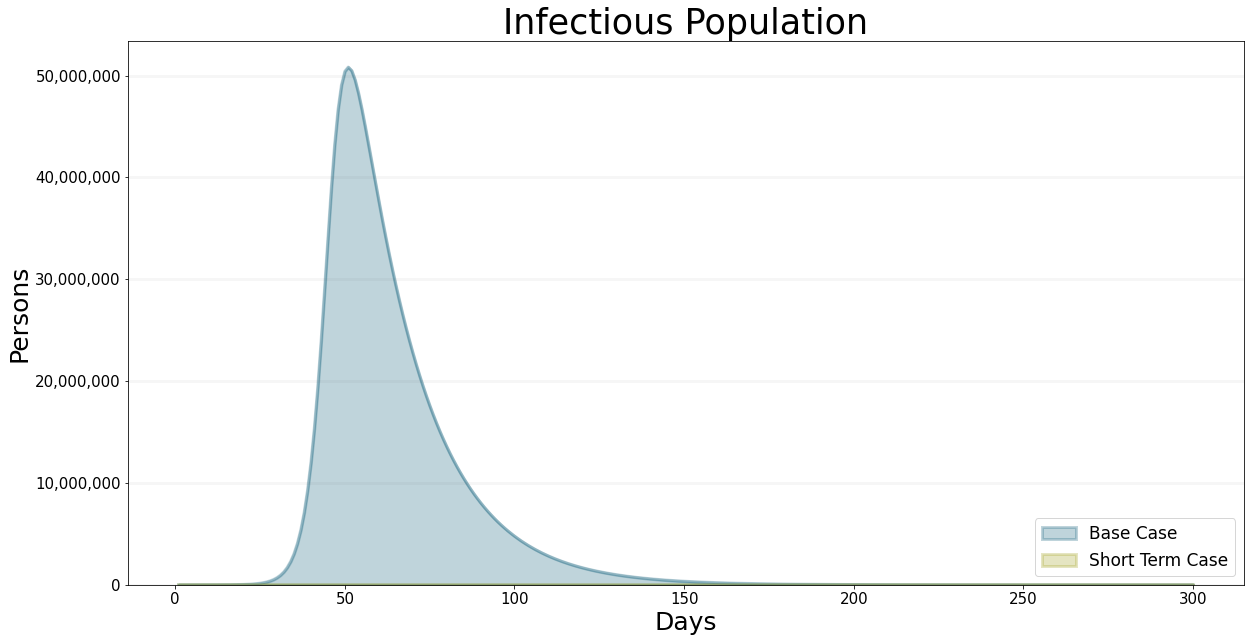

In [50]:
bptk.plot_scenarios(
    scenario_managers=["smSir"],
    scenarios=["contactTwoPeople","base"],
    title="Infectious Population",
    x_label="Days",
    y_label="Persons",
    equations=["I"],
    series_names={
        "smSir_base_I" : "Base Case",
        "smSir_contactTwoPeople_I" : "Short Term Case"
    },
    visualize_to_period=300
    
)

Comparing this scenario with the base scenario shows that the problem is shifted to a later point in time. This means taking measures for only a short period of time won't stem the virus. 

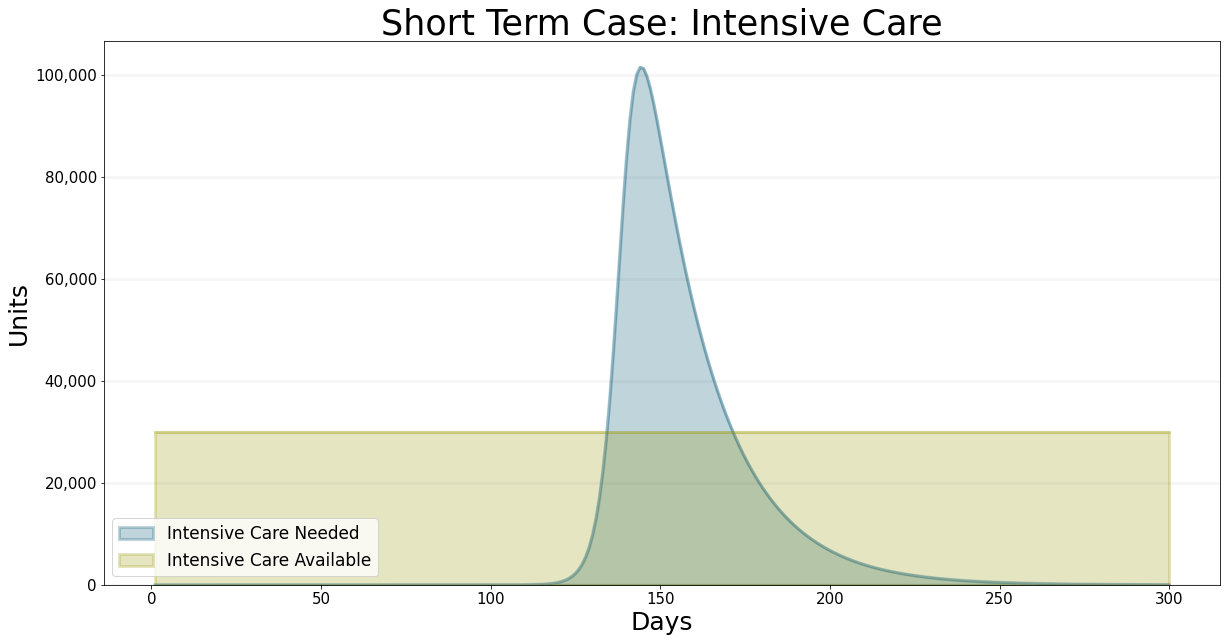

In [32]:
bptk.plot_scenarios(
    scenario_managers=["smSir"],
    scenarios=["contactTwoPeople"],
    title="Short Term Case: Intensive Care",
    x_label="Days",
    y_label="Units",
    equations=["needed","available"],
    series_names={
        "smSir_contactTwoPeople_needed" : "Intensive Care Needed",
        "smSir_contactTwoPeople_available" : "Intensive Care Available" 
    },
    visualize_to_period=300
)

As expected, there are not enough intensive care units but only at a later point of time.

## Summary

Though this is actually quite a simple model with only few parameters, we can already simulate some interesting aspects of the COVID-19 pandemic:

* The behaviour over the first 25 days fits nicely with the situation in Germany
* If no measures are taken, we will experience expontential growth of COVID-19 cases in a very short period of time
* Implementing harsh social distancing methods leads to the desired result of keeping the number of COVID-19 cases low and not putting to much strain on the health care system.
* Unfortunately the social distancing measures have to be kept up for quite some time in order to have an effect.
